# Drift Simulator

## Imports

In [2]:
from datetime import timedelta
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

## User Specifications

In [1]:
drift_model = 'turnbull'  # must be 'turnbull' or 'wagner'
ocean_model = 'ecmwf'  # must be 'ecmwf'
atm_model = 'ecmwf'  # must be 'ecmwf'
tstepper = 'euler'  # must be euler, ab2, ab3, or ab4

In [2]:
from icedef import iceberg, metocean, plot, timesteppers

if drift_model == 'turnbull':
    from icedef.turnbull import drift
elif drift_model == 'wagner':
    from icedef.wagner import drift
else:
    print('drift model specified is invalid')
    
if tstepper == 'euler':
    from icedef.timesteppers import euler as timestepper
elif tstepper == 'ab2':
    from icedef.timesteppers import ab2 as timestepper
elif tstepper == 'ab3':
    from icedef.timesteppers import ab3 as timestepper
elif tstepper == 'ab4':
    from icedef.timesteppers import ab4 as timestepper
else:
    print('timestepper specified is invalid')

## Iceberg Data

In [3]:
iip_season = 2015
max_hours = 24

In [4]:
iip_df = iceberg.get_dense_df(iip_season, max_hours)

/home/evankielley/IceDEF/icedef/iceberg.py:403: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  iip_df2['count'] = iip_df2.groupby('ICEBERG_NUMBER')['ICEBERG_NUMBER'].transform('count')


In [5]:
track_num = 0
iip_berg_df = iip_df.loc[iip_df['track_num'] == track_num]

In [6]:
iip_berg = iceberg.get_iip_berg(iip_berg_df)

## Metocean Data

In [7]:
ocean_data = metocean.ECMWF_Ocean(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])

ocean_data.filenames

['20150310.nc', '20150311.nc']

In [8]:
atm_data = metocean.ECMWF_Atm(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])

atm_data.filenames

['20150310.nc', '20150311.nc']

## Simulate Drift

In [9]:
vary_currents = True
vary_winds = True
vary_drag_coeffs = True
vary_berg_dims = True
vary_berg_initial_vels = True



# Timesteps
dt = 0.1  # timestep in hours
t0 = iip_berg.history['T'][0]
tf = iip_berg.history['T'][-1]

t_all = timesteppers.get_all_timesteps(t0, tf, dt)

    
    

# Current and wind subsets
UW_data_subset = metocean.get_data_subset(ocean_data.UW, ocean_data.xy_res, ocean_data.lats, ocean_data.lons, 
            min(iip_berg.history['Y']), max(iip_berg.history['Y']), 
            min(iip_berg.history['X']), max(iip_berg.history['X']))
VW_data_subset = metocean.get_data_subset(ocean_data.VW, ocean_data.xy_res, ocean_data.lats, ocean_data.lons, 
                min(iip_berg.history['Y']), max(iip_berg.history['Y']), 
                min(iip_berg.history['X']), max(iip_berg.history['X']))

UA_data_subset = metocean.get_data_subset(atm_data.UA, atm_data.xy_res, atm_data.lats, atm_data.lons, 
                min(iip_berg.history['Y']), max(iip_berg.history['Y']), 
                min(iip_berg.history['X']), max(iip_berg.history['X']))
VA_data_subset = metocean.get_data_subset(atm_data.VA, atm_data.xy_res, atm_data.lats, atm_data.lons, 
                min(iip_berg.history['Y']), max(iip_berg.history['Y']), 
                min(iip_berg.history['X']), max(iip_berg.history['X']))


    

    
num_runs = 10  
mod_berg_list = []

for run_num in range(num_runs):
    
    # Get offset that will be applied to all current and wind values
    if vary_currents:
        UW_offset = metocean.get_current_offset(UW_data_subset)
        VW_offset = metocean.get_current_offset(VW_data_subset)

    if vary_winds:
        UA_offset = metocean.get_wind_offset(UA_data_subset)
        VA_offset = metocean.get_wind_offset(VA_data_subset)



    # Model iceberg
    mod_berg = iceberg.clone_iceberg_state(iip_berg)

    if vary_drag_coeffs:
        mod_berg.vary_all_drag_coeffs()

    if vary_berg_dims:
        mod_berg.vary_all_dims()

    if vary_berg_initial_vels:
        # Iceberg travels at roughly 2% of the wind speed (rule of thumb)
        UA_mean = metocean.get_data_stats(UA_data_subset)[0]
        mod_berg.Vx = 0.02*UA_mean
        VA_mean = metocean.get_data_stats(VA_data_subset)[0]
        mod_berg.Vy = 0.02*VA_mean

        
    mod_berg = timesteppers.wrapper(mod_berg, ocean_data, atm_data, drift, timestepper, t_all)


    print("Final time: {}".format(mod_berg.T)) 
    mod_berg_list.append(mod_berg)

Final time: 2015-03-11 11:10:00
Final time: 2015-03-11 11:10:00
Final time: 2015-03-11 11:10:00
Final time: 2015-03-11 11:10:00
Final time: 2015-03-11 11:10:00
Final time: 2015-03-11 11:10:00
Final time: 2015-03-11 11:10:00
Final time: 2015-03-11 11:10:00
Final time: 2015-03-11 11:10:00
Final time: 2015-03-11 11:10:00


## Plotting

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


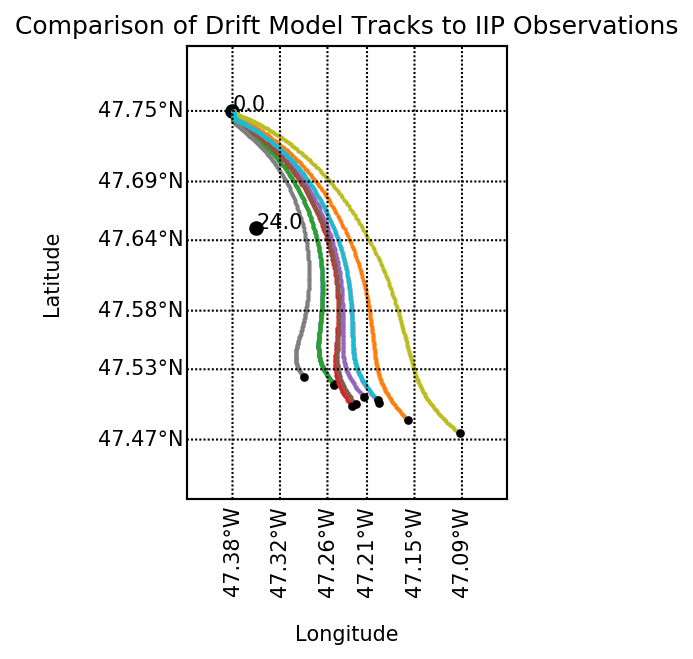

In [10]:
plot.plot_spaghetti_test_case(iip_berg, mod_berg_list)

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


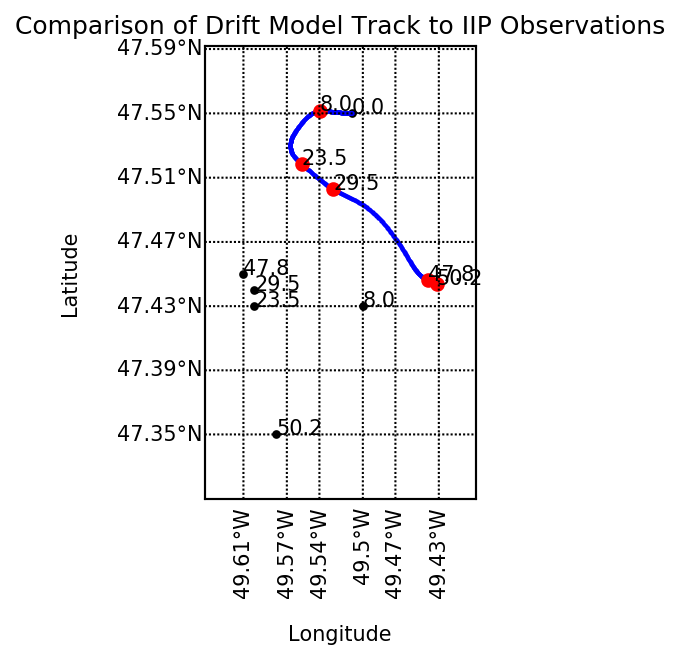

In [31]:
plot.plot_drift_track_test_case(iip_berg, mod_berg4)

### Compare different time steppers

In [11]:
with PdfPages('tsteppers.pdf') as pdf:

    t_step_list = [0.1, 0.2, 0.4, 0.8, 1.6]
    
    for t_step_hours in t_step_list:

        # Timesteps
        t0 = iip_berg.history['T'][0]
        tf = iip_berg.history['T'][-1]
        dt = t_step_hours
        
        t_all = timesteppers.get_all_timesteps(t0, tf, dt)

        mod_berg_list = []
        
        figure = plt.figure()
        labels = ['Euler', 'AB2', 'AB3', 'AB4']
        tstepper_list = [timesteppers.euler, timesteppers.ab2, timesteppers.ab3, timesteppers.ab4]
        
        for indx, tstepper in enumerate(tstepper_list):
            
            mod_berg = iceberg.clone_iceberg_state(iip_berg)
            mod_berg = tstepper(mod_berg, ocean_data, atm_data, drift, t_all)
            mod_berg_list.append(mod_berg)
            
            # plot drift track if in bounds
            if not mod_berg.out_of_bounds:
                plt.scatter(mod_berg.history['X'], mod_berg.history['Y'], label=labels[indx], s=2)
            
            
        plt.title(f'Iceberg Drift with Timestep of {t_step_hours} hrs')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.legend()
        pdf.savefig()
        plt.close()

Iceberg out-of-bounds
Iceberg out-of-bounds
Iceberg out-of-bounds
Iceberg out-of-bounds
Iceberg out-of-bounds
